In [1]:
#importing libraries
import pathlib
import tensorflow as tf

from google.colab import drive
from matplotlib import pyplot as plt

In [2]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
%cd gdrive/MyDrive/CNN_FPGA_project

/content/gdrive/MyDrive/CNN_FPGA_project


In [4]:
#Image IO
import cv2
import numpy as np

##File IO
dirname = "breast_cancer_ultrasound"
class_names = ["benign", "malignant"]

image_no = 100

dataset = {
    "input": [],
    "output": []
}

IMG_SIZE = (224, 224)

for i in range(1, image_no+1, 1):
    pathname = f"./{dirname}/{class_names[0]}/us{i}.bmp"
    benign = cv2.imread(pathname)
    benign = cv2.resize(benign ,IMG_SIZE)

    pathname = f"./{dirname}/{class_names[1]}/us{i+100}.bmp"
    malignant = cv2.imread(pathname)
    malignant = cv2.resize(malignant,IMG_SIZE)

    dataset["input"].append(benign)
    dataset["input"].append(malignant)

    dataset["output"].append(0)
    dataset["output"].append(1)

dataset["input"] = np.array(dataset["input"])
dataset["output"] = np.array(dataset["output"])

##copying dataset for transfer learning
transfer_in = dataset["input"]
transfer_out = dataset["output"]

In [5]:
#Data pre-processing
temp = []
#Gray scaling
for i in range(len(dataset["input"])):
    temp.append(cv2.cvtColor(dataset["input"][i], cv2.COLOR_BGR2GRAY))
#Normalisation
for i in range(len(dataset["input"])):
    temp[i] = temp[i]/255;

dataset["input"] = np.array(temp, dtype="float32")

In [6]:
def generator_ffnn():
    yield [dataset["input"][np.random.randint(0, len(dataset["input"]))]]
def generator_transfer():
    yield [transfer_in.astype("float32")]

In [7]:
converter = tf.lite.TFLiteConverter.from_saved_model("./ffnn/model")
tflite_ffnn = converter.convert()

converter = tf.lite.TFLiteConverter.from_saved_model("./cnn/model")
tflite_cnn = converter.convert()

converter = tf.lite.TFLiteConverter.from_saved_model("./transfer/model")
tflite_transfer = converter.convert()

mem_without_quantization = [len(tflite_ffnn), len(tflite_cnn), len(tflite_transfer)]
mem_with_quantization = []

In [8]:
converter = tf.lite.TFLiteConverter.from_saved_model("./ffnn/model")

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = tf.lite.RepresentativeDataset(generator_ffnn)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_ffnn = converter.convert()
mem_with_quantization.append(len(tflite_ffnn))

tflite_model_file = pathlib.Path("ffnn/ffnn.tflite")
tflite_model_file.write_bytes(tflite_ffnn)

3127160

In [9]:
converter = tf.lite.TFLiteConverter.from_saved_model("./cnn/model")

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_cnn = converter.convert()
mem_with_quantization.append(len(tflite_cnn))


tflite_model_file = pathlib.Path("cnn/cnn.tflite")
tflite_model_file.write_bytes(tflite_cnn)

12624

In [10]:
converter = tf.lite.TFLiteConverter.from_saved_model("./transfer/model")

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = tf.lite.RepresentativeDataset(generator_transfer)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_transfer = converter.convert()
mem_with_quantization.append(len(tflite_transfer))


tflite_model_file = pathlib.Path("transfer/transfer.tflite")
tflite_model_file.write_bytes(tflite_transfer)

2857112

In [11]:
ffnn = tf.keras.models.load_model("./ffnn/model")
ffnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 62)                3110974   
                                                                 
 dense_1 (Dense)             (None, 190)               11970     
                                                                 
 dense_2 (Dense)             (None, 2)                 382       
                                                                 
Total params: 3,123,326
Trainable params: 3,123,326
Non-trainable params: 0
_________________________________________________________________


In [12]:
cnn = tf.keras.models.load_model("./cnn/model")
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 3)         51        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 3)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 2)         26        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 2)          0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 162)               0         
                                                                 
 dense (Dense)               (None, 14)                2

In [13]:
transfer = tf.keras.models.load_model("./transfer/model")
transfer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 94)                120414    
                                                                 
 dense_1 (Dense)             (None, 2)                 190       
                                                                 
Total params: 2,378,588
Trainable params: 120,604
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
_, ffnn_acc = ffnn.evaluate(dataset["input"], dataset["output"])
_, cnn_acc = cnn.evaluate(dataset["input"], dataset["output"])
_, transfer_acc =transfer.evaluate(transfer_in, transfer_out)

7/7 [==============================] - 6s 819ms/step - loss: 0.1733 - accuracy: 0.9300


In [15]:
acc_pre_quant = [ffnn_acc, cnn_acc, transfer_acc]

<BarContainer object of 1 artists>

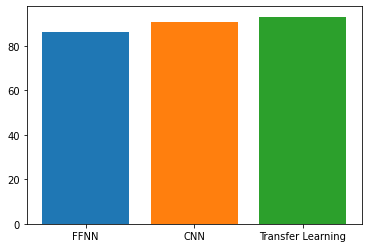

In [16]:
plt.bar(["FFNN"], 100*ffnn_acc)
plt.bar(["CNN"], 100*cnn_acc)
plt.bar(["Transfer Learning"], 100*transfer_acc)

In [17]:
interpreter = tf.lite.Interpreter(model_content=tflite_ffnn)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

output = []
for i in range(image_no*2):
    interpreter.set_tensor(input_details[0]["index"], [dataset["input"][i].astype("float32").reshape((224, 224, 1))])
    interpreter.invoke()

    output.append(np.argmax(interpreter.get_tensor(output_details[0]["index"])))

In [18]:
ffnn_output = output == dataset["output"]
ffnn_acc =ffnn_output.astype("int").mean()

In [19]:
interpreter = tf.lite.Interpreter(model_content=tflite_cnn)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

output = []
for i in range(image_no*2):
    interpreter.set_tensor(input_details[0]["index"], [dataset["input"][i].astype("float32").reshape((224, 224, 1))])
    interpreter.invoke()

    output.append(np.argmax(interpreter.get_tensor(output_details[0]["index"])))

In [20]:
cnn_output = output == dataset["output"]
cnn_acc =cnn_output.astype("int").mean()

In [21]:
interpreter = tf.lite.Interpreter(model_content=tflite_transfer)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

output = []
for i in range(image_no*2):
    interpreter.set_tensor(input_details[0]["index"], [transfer_in[i].astype("float32").reshape((224, 224, 3))])
    interpreter.invoke()

    output.append(np.argmax(interpreter.get_tensor(output_details[0]["index"])))

In [22]:
transfer_output = output == dataset["output"]
transfer_acc =transfer_output.astype("int").mean()

In [23]:
acc_post_quant = [ffnn_acc, cnn_acc, transfer_acc]
acc_post_quant

[0.875, 0.905, 0.88]

<BarContainer object of 1 artists>

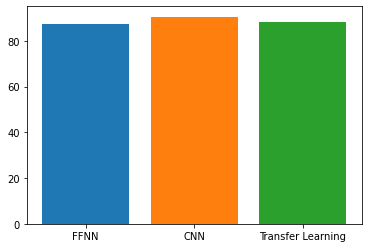

In [24]:
plt.bar(["FFNN"], 100*ffnn_acc)
plt.bar(["CNN"], 100*cnn_acc)
plt.bar(["Transfer Learning"], 100*transfer_acc)

In [25]:
print(mem_without_quantization)
print(mem_with_quantization)

[12495628, 28624, 9373248]
[3127160, 12624, 2857112]


<BarContainer object of 3 artists>

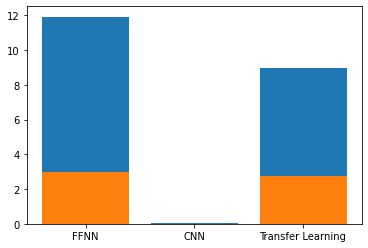

In [26]:
#in MB
plt.bar(["FFNN", "CNN", "Transfer Learning"], np.array(mem_without_quantization)/float(2**20))
plt.bar(["FFNN", "CNN", "Transfer Learning"], np.array(mem_with_quantization)/float(2**20))

<BarContainer object of 1 artists>

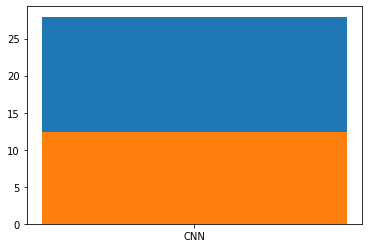

In [27]:
#in KB for CNN
plt.bar(["CNN"], mem_without_quantization[1]/float(2**10), width=0.5)
plt.bar(["CNN"], mem_with_quantization[1]/float(2**10), width=0.5)

In [28]:
for nn, mem, quant in zip(["FFNN", "CNN", "Transfer Learning"], mem_without_quantization, mem_with_quantization):
    print(f"Memory of {nn} is reduced by {np.round((mem - quant)/mem * 100)}% through the method of quantization.")
print(50*"--")
for nn, mem, quant in zip(["FFNN", "CNN", "Transfer Learning"], acc_pre_quant, acc_post_quant):
    print(f"Accuracy of {nn} is reduced by {(np.round((mem - quant)/mem * 100))}% through the method of quantization.")

Memory of FFNN is reduced by 75.0% through the method of quantization.
Memory of CNN is reduced by 56.0% through the method of quantization.
Memory of Transfer Learning is reduced by 70.0% through the method of quantization.
----------------------------------------------------------------------------------------------------
Accuracy of FFNN is reduced by -2.0% through the method of quantization.
Accuracy of CNN is reduced by -0.0% through the method of quantization.
Accuracy of Transfer Learning is reduced by 5.0% through the method of quantization.


In [29]:
!xxd -i ./ffnn/ffnn.tflite > ./ffnn/ffnn.c
!xxd -i ./cnn/cnn.tflite > ./cnn/cnn.c
!xxd -i ./transfer/transfer.tflite > ./transfer/transfer.c